<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter11/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoders
In essence, in VAE, we are specifying that the bottleneck layer should follow a certain distribution. In the next sections, we will learn about the strategy we adopt with VAE, and we will also learn about KL divergence loss, which helps us fetch bottleneck features that follow a certain distribution.  

In a VAE, we are building the network in such a way that a random vector that is generated from a pre-defined distribution can generate a realistic image. This was not possible with a simple autoencoder, as we did not specify the distribution of data that generates an image in the network. We enable that with a VAE by adopting the following strategy:

1. The output of the encoder is two vectors for each image: One vector represents the mean. The other represents the standard deviation.

2. From these two vectors, we fetch a modified vector that is the sum of the mean and standard deviation (which is multiplied by a random small number). The modified vector will be of the same number of dimensions as each vector.

3. The modified vector obtained in the previous step is passed as input to the decoder to fetch the image.

4. The loss value that we optimize for is a combination of the mean squared error and the KL divergence loss:

    - KL divergence loss measures the deviation of the distribution of the mean vector and the standard deviation vector from 0 and 1, respectively.

    - Mean squared loss is the optimization we use to re-construct (decode) an image.



By specifying that the mean vector should have a distribution centered around 0 and the standard deviation vector should be centered around 1, we are training the network in such a way that when we generate random noise with a mean of 0 and standard deviation of 1, the decoder will be able to generate a realistic image.

Further, note that, had we only minimized KL divergence, the encoder would have predicted a value of 0 for the mean vector and a standard deviation of 1 for every input. Thus, it is important to minimize KL divergence loss and mean squared loss together.


## KL Divergence
we want our bottleneck feature values to be following a normal distribution with a mean of 0 and a standard deviation of 1.  
Thus, we use KL divergence loss to understand how different our bottleneck feature values are with respect to the expected distribution of values having a mean of 0 and a standard deviation of 1.

Let's take a look at how KL divergence loss helps by going through how it is calculated:

$$ \sum_{i=1}^{n} \sigma_i^2 +\mu_i^2 - log(\sigma_i) -1$$




In [1]:
# !pip install -q torch_snippets
from torch_snippets import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataset = datasets.MNIST(root='~/datasets/MNIST/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='~/datasets/MNIST/', train=False, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /home/guy/datasets/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to /home/guy/datasets/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /home/guy/datasets/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to /home/guy/datasets/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /home/guy/datasets/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/guy/datasets/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /home/guy/datasets/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/guy/datasets/MNIST/MNIST/raw



## Building the VAE
note that the VAE is made from fully connected layers

In [2]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        self.d1 = nn.Linear(x_dim, h_dim1)
        self.d2 = nn.Linear(h_dim1, h_dim2)
        self.d31 = nn.Linear(h_dim2, z_dim)
        self.d32 = nn.Linear(h_dim2, z_dim)
        self.d4 = nn.Linear(z_dim, h_dim2)
        self.d5 = nn.Linear(h_dim2, h_dim1)
        self.d6 = nn.Linear(h_dim1, x_dim)
    def encoder(self, x):
        h = F.relu(self.d1(x))
        h = F.relu(self.d2(h))
        return self.d31(h), self.d32(h)
    def sampling(self, mean, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)
    def decoder(self, z):
        h = F.relu(self.d4(z))
        h = F.relu(self.d5(h))
        return F.sigmoid(self.d6(h))
    def forward(self, x):
        mean, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mean, log_var)
        return self.decoder(z), mean, log_var


In [3]:
def train_batch(data, model, optimizer, loss_function):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon_batch, data, mean, log_var)
    loss.backward()
    optimizer.step()
    return loss, mse, kld, log_var.mean(), mean.mean()

@torch.no_grad()
def validate_batch(data, model, loss_function):
    model.eval()
    data = data.to(device)
    recon, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon, data, mean, log_var)
    return loss, mse, kld, log_var.mean(), mean.mean()

In [4]:
def loss_function(recon_x, x, mean, log_var):
    RECON = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return RECON + KLD, RECON, KLD

In [5]:
vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=50).to(device)
optimizer = optim.AdamW(vae.parameters(), lr=1e-3)

/home/guy/anaconda3/envs/ptvit/lib/python3.8/site-packages/torch-1.10.1-py3.8-linux-x86_64.egg/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


EPOCH: 1.000	train_loss: 2937.228	train_kld: 257.516	train_recon: 2679.712	train_log_var: -0.156	train_mean: -0.000	val_loss: 2377.067	val_kld: 472.716	val_recon: 1904.352	val_log_var: -0.277	val_mean: 0.006	(6.54s - 58.88s remaining)


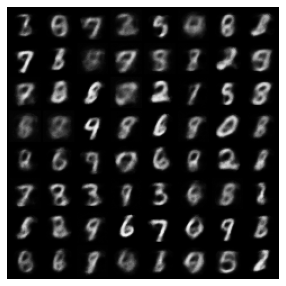

EPOCH: 2.000	train_loss: 2235.095	train_kld: 489.128	train_recon: 1745.968	train_log_var: -0.297	train_mean: -0.001	val_loss: 2109.608	val_kld: 523.315	val_recon: 1586.293	val_log_var: -0.331	val_mean: 0.005	(13.14s - 52.54s remaining)


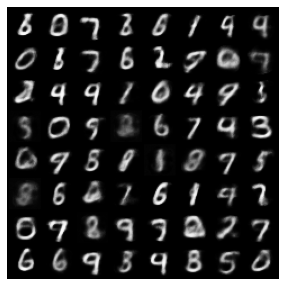

EPOCH: 3.000	train_loss: 2072.753	train_kld: 542.968	train_recon: 1529.785	train_log_var: -0.334	train_mean: -0.000	val_loss: 1995.825	val_kld: 555.774	val_recon: 1440.051	val_log_var: -0.332	val_mean: 0.009	(19.86s - 46.35s remaining)


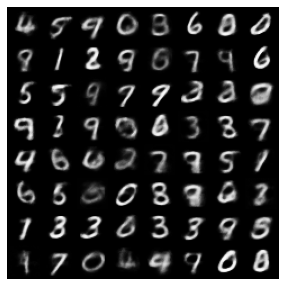

EPOCH: 4.000	train_loss: 1999.542	train_kld: 572.650	train_recon: 1426.892	train_log_var: -0.354	train_mean: 0.000	val_loss: 1953.831	val_kld: 594.821	val_recon: 1359.010	val_log_var: -0.365	val_mean: -0.002	(26.59s - 39.89s remaining)


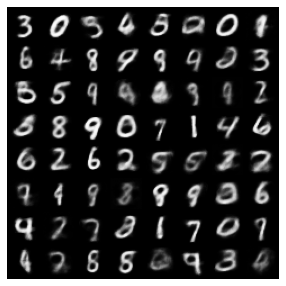

EPOCH: 5.000	train_loss: 1957.279	train_kld: 589.631	train_recon: 1367.648	train_log_var: -0.365	train_mean: 0.000	val_loss: 1926.665	val_kld: 590.468	val_recon: 1336.197	val_log_var: -0.369	val_mean: 0.005	(33.27s - 33.27s remaining)


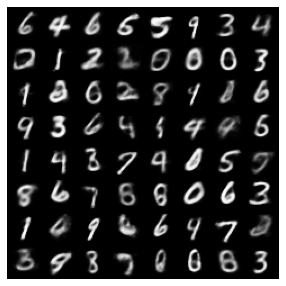

EPOCH: 6.000	train_loss: 1927.995	train_kld: 601.421	train_recon: 1326.575	train_log_var: -0.374	train_mean: -0.000	val_loss: 1902.045	val_kld: 586.071	val_recon: 1315.974	val_log_var: -0.367	val_mean: 0.007	(39.96s - 26.64s remaining)


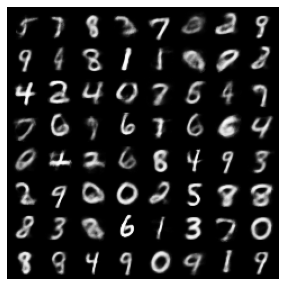

EPOCH: 7.000	train_loss: 1905.299	train_kld: 610.769	train_recon: 1294.531	train_log_var: -0.380	train_mean: -0.000	val_loss: 1882.194	val_kld: 625.754	val_recon: 1256.440	val_log_var: -0.385	val_mean: 0.005	(46.69s - 20.01s remaining)


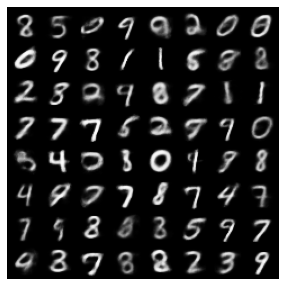

EPOCH: 8.000	train_loss: 1885.732	train_kld: 617.053	train_recon: 1268.679	train_log_var: -0.384	train_mean: -0.000	val_loss: 1873.202	val_kld: 619.583	val_recon: 1253.619	val_log_var: -0.388	val_mean: 0.008	(53.36s - 13.34s remaining)


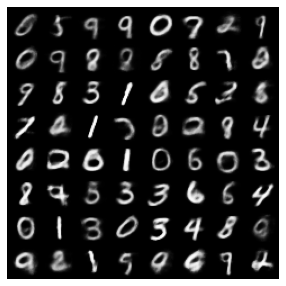

EPOCH: 9.000	train_loss: 1870.782	train_kld: 624.032	train_recon: 1246.750	train_log_var: -0.389	train_mean: -0.000	val_loss: 1847.702	val_kld: 605.085	val_recon: 1242.617	val_log_var: -0.380	val_mean: 0.004	(60.10s - 6.68s remaining)


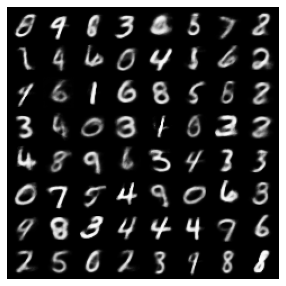

EPOCH: 10.000	train_loss: 1859.529	train_kld: 628.534	train_recon: 1230.994	train_log_var: -0.392	train_mean: 0.000	val_loss: 1842.773	val_kld: 638.231	val_recon: 1204.542	val_log_var: -0.401	val_mean: 0.001	(66.74s - 0.00s remaining)


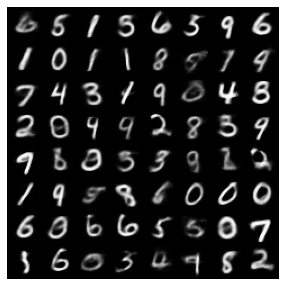

In [6]:
n_epochs = 10
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(train_loader)
    for batch_idx, (data, _) in enumerate(train_loader):
        loss, recon, kld, log_var, mean = train_batch(data, vae, optimizer, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, train_loss=loss, train_kld=kld, train_recon=recon, train_log_var=log_var, train_mean=mean, end='\r')
        
    N = len(test_loader)
    for batch_idx, (data, _) in enumerate(test_loader):
        loss, recon, kld, log_var, mean = validate_batch(data, vae, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, val_loss=loss, val_kld=kld, val_recon=recon, val_log_var=log_var, val_mean=mean, end='\r')
        
    log.report_avgs(epoch+1)
    with torch.no_grad():
        z = torch.randn(64, 50).to(device)
        sample = vae.decoder(z).to(device)
        images = make_grid(sample.view(64, 1, 28, 28)).permute(1,2,0)
        show(images)

100%|██████████| 111/111 [00:00<00:00, 735.40it/s]


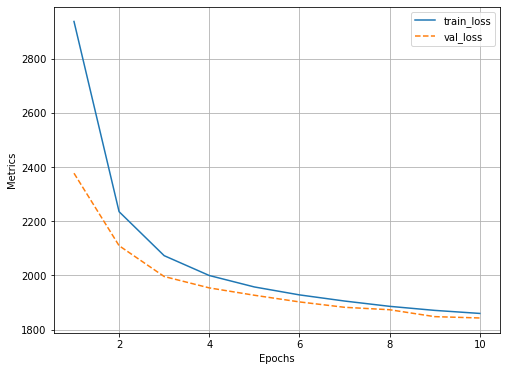

In [7]:
log.plot_epochs(['train_loss','val_loss'])